# Theory & Applications for the correlation in pairwise differences

This notebook shows the recreation of plots showing the theoretical impact of time-stratified sampling 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
import pandas as pd

import sys
sys.path.append('../../src/')
from coal_cov import *
from seg_sites_covar import CorrSegSites
from draw_demography import *
from plot_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
main_figdir = '../../plots/two_locus_stats/'
supp_figdir = '../../plots/supp_figs/two_locus_stats/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

In [3]:
def estNe(t2s):
    """Given modern estimate of t2s calculate Ne."""
    return(np.mean(t2s)/2./2.)

def plot_bot_demo(ax, N0=1e4, T_bot=100, b=0.1, **kwargs):
    """Plot bottleneck demography."""
    xs = np.arange(0, int(10*T_bot))
    ns = np.repeat(N0, xs.size)
    ns[T_bot:] = N0*b
    ax.plot(xs,ns, **kwargs)
    
def corr_bl_2_corr_pi_kb(ta, corr_bl, theta=0.4):
    """Compute the correlation in pairwise diversity using the correlation in branch length."""
    coeff = 1. / (1. + (2 + (ta /2./Ne)/theta))
    corr_pi = coeff * corr_bl
    return(corr_pi, coeff)

100%|██████████| 2/2 [00:00<00:00, 48.87it/s]


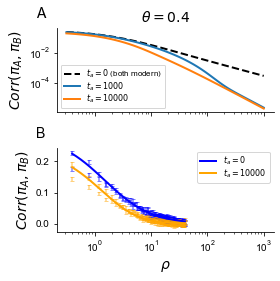

In [4]:
# Plotting just the first two plots
fig, axs = plt.subplots(2,1, figsize=(4,4), sharex=True, tight_layout=True)
# gs = fig.add_gridspec(3, 6)
ax1 = axs[0]; debox(ax1)

# Plot A: Theoretical Results
rhos2_t = 10**np.linspace(-0.5, 3, 100)
theta = 0.4
ta = 1000
Ne = 1e4
ax1.plot(rhos2_t, TwoLocusTheoryConstant._corrSASB(rhos2_t, 0., theta=theta), 
          linestyle='--', lw=2, color='black', label=r'$t_a = 0$ (both modern)')
ax1.plot(rhos2_t, TwoLocusTheoryConstant._corrSASB(rhos2_t, ta/Ne/2., theta=theta), 
        lw=2, label=r'$t_a = %d$' % ta)
ax1.plot(rhos2_t, TwoLocusTheoryConstant._corrSASB(rhos2_t, ta*10/Ne/2., theta=theta), 
        lw=2, label=r'$t_a = %d$' % (ta*1e1))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r'$\theta = %0.1f$' % theta, fontsize=14)

ax1.legend(fontsize=8, labelspacing=-0.0)

# Plots 
ax2 = axs[1]; debox(ax2)
colors = {0:'blue', 10000:'orange'}
tas = [0,10000]
rec_rates = np.logspace(-5,-3, 1000)
Ne=1e4

#Paired Correlations 
corr_s1_s2_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.csv')
corr_s1_s2_df = corr_s1_s2_df.dropna()

for t in tqdm(tas):
    df = corr_s1_s2_df[(corr_s1_s2_df.scenario == 'SerialConstant') & (corr_s1_s2_df.ta == t)] 
    rec_rate_mean = df.rec_rate_mean
    rec_rate_se = df.rec_rate_se
    corr_s1_s2 = df.corr_s1_s2
    se_r = df.se_corr
    ax2.errorbar(4*Ne*rec_rate_mean, corr_s1_s2, yerr=2*se_r, 
                capsize=2, ls='none', alpha=0.5, color=colors[t])
    
    ax2.plot(4*Ne*rec_rates, TwoLocusTheoryConstant._corrSASB(4*Ne*rec_rates, ta=t/Ne/2, theta=4*Ne*1e3*1e-8), 
            zorder=10, color=colors[t], lw=2, label=r'$t_a = %d$' % t)
ax2.legend(fontsize=8, labelspacing=-0.0)
ax2.set_xscale('log')
ax2.set_xlabel(r'$\rho$', fontsize=14)    
    
    
# Labeling all of the axes
for (axi,lbl) in zip([ax1, ax2],['A','B']):
    axi.text(-0.05, 1.25, lbl, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axi.transAxes);

ax1.set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
ax2.set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)

# fig.text(-0.025, 0.55, r'$Corr(\pi_A, \pi_B)$', 
#          fontsize=14, va='center', rotation='vertical')    

plt.tight_layout()
plt.savefig(main_figdir + 'corr_seg_sites_theory_sims.pdf', dpi=300, bbox_inches='tight')

## The effect of demography on the correlation in branch length

100%|██████████| 3/3 [00:00<00:00, 133.23it/s]


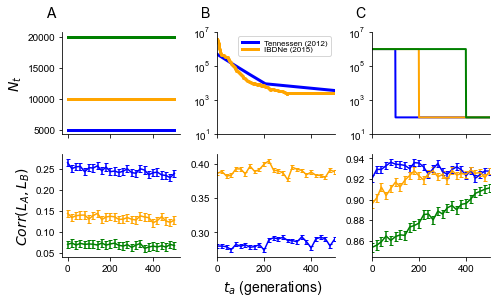

In [5]:
## ------ Figure of   ------- ##
fig, axs = plt.subplots(2,3, figsize=(7, 4), sharex='col')

# Part 1: Constant population size
ax3 = axs[0,0]; debox(ax3)
ax4 = axs[1,0]; debox(ax4)

# Loading in the metadata for correlation in branch length
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# compute the asymptotic standard errors (Note - these are similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in tqdm(Ns):
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.
#     print(Ne_hat, cur_df.Ne.values[0])
    
    ax3.plot(tas, np.repeat(n,tas.size), lw=3, color=colors[i])
    # Note - this is a fixed theta here ... 
    theta = 4 * cur_df.Ne.values[0] * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    # Note - we linearly scale the standard error here ... 
#     ax4.errorbar(cur_df.ta, corr_pi,  yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
    ax4.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])
    i += 1


ax5 = axs[0,1]; debox(ax5)
# Plot both demographies
demo_model1_file = {'Tennessen (2012)': '../../data/demo_models/tennessen_european.txt', 
                    'IBDNe (2015)': '../../data/demo_models/uk10k.IBDNe.txt'}
i = 0
for x in demo_model1_file:
    _,demo = read_demography(demo_model1_file[x])
    t,nt = generate_demography(demo)
    ax5.plot(t,nt,lw=3,label=x, color=colors[i])
    i += 1
ax5.set_yscale('log')
ax5.set_ylim(1e1,1e7)
ax5.set_xlim(0, 500)
ax5.legend(fontsize=8, labelspacing=-0.0)


ax6 = axs[1,1]; debox(ax6)

# Plot the Tennessen et al model...
i = 0
cur_df = corr_bl_df[corr_bl_df.scenario == 'Tennessen']
mean_et2 = np.mean(cur_df.exp_bl)
Ne_hat = mean_et2/2./2.
# print(Ne_hat, cur_df.Ne.values[0])
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
# ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
ax6.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])


# Plot the UK10K results
i = 1
cur_df = corr_bl_df[corr_bl_df.scenario == 'IBDNeUK10K']
mean_et2 = np.mean(cur_df.exp_bl)
Ne_hat = mean_et2/2./2.
# print(Ne_hat, cur_df.Ne.values[0])
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
# ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
ax6.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])


ax7 = axs[0,2]; debox(ax7)
tbot = [100,200,400]
i = 0
for tb in tbot:
    plot_bot_demo(ax7, N0=1e6, T_bot=tb, b=0.0001, lw=2, color=colors[i])
    i += 1

ax7.set_yscale('log')
ax7.set_ylim(1e1,1e7)
ax7.set_xlim(0,500)
    
ax8 = axs[1,2]; debox(ax8)
i = 0 
for x in tqdm([7,8,9]):
    
    cur_df = corr_bl_df[corr_bl_df.scenario == 'InstantGrowth%d' % x]
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.
    theta = 4 * Ne_hat * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    ax8.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])
    i += 1

    
# Labeling all of the axes
for (axi,lbl) in zip([axs[0,0], axs[0,1], axs[0,2]],['A','B','C']):
    axi.text(-0.06, 1.25, lbl, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axi.transAxes);


axs[0,0].set_ylabel(r'$N_t$', fontsize=14)
axs[1,0].set_ylabel(r'$Corr(L_A,L_B)$', fontsize=14)
plt.tight_layout()

fig.text(0.45, -0.025, r'$t_a$ (generations)', fontsize=14)
plt.savefig(main_figdir + 'full_demography.corr_branch_len.pdf', dpi=300, bbox_inches='tight')

## The effect of demography on the correlation in pairwise differences

100%|██████████| 3/3 [00:00<00:00, 129.53it/s]


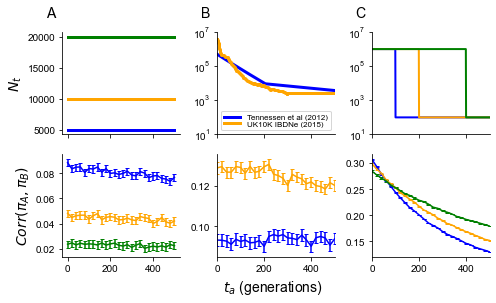

In [6]:
## ------ Testing figure  ------- ##
fig, axs = plt.subplots(2,3, figsize=(7, 4), sharex='col')

# Part 1: Constant population size
ax3 = axs[0,0]; debox(ax3)
ax4 = axs[1,0]; debox(ax4)

# Loading in the metadata for correlation in branch length
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# compute the asymptotic standard errors (Note - these are similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in tqdm(Ns):
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    
    ax3.plot(tas, np.repeat(n,tas.size), lw=3, color=colors[i])
    # Note - this is a fixed theta here ... 
    theta = 4 * cur_df.Ne.values[0] * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    # Note - we linearly scale the standard error here ... 
    ax4.errorbar(cur_df.ta, corr_pi,  yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
    i += 1


ax5 = axs[0,1]; debox(ax5)
# Plot both demographies
demo_model1_file = {'Tennessen et al (2012)': '../../data/demo_models/tennessen_european.txt', 
                    'UK10K IBDNe (2015)': '../../data/demo_models/uk10k.IBDNe.txt'}
i = 0
for x in demo_model1_file:
    _,demo = read_demography(demo_model1_file[x])
    t,nt = generate_demography(demo)
    ax5.plot(t,nt,lw=3,label=x, color=colors[i])
    i += 1
ax5.set_yscale('log')
ax5.set_ylim(1e1,1e7)
ax5.set_xlim(0, 500)
ax5.legend(fontsize=8, labelspacing=-0.0)


ax6 = axs[1,1]; debox(ax6)

# Plot the Tennessen et al model...
i = 0
cur_df = corr_bl_df[corr_bl_df.scenario == 'Tennessen']
mean_et2 = np.mean(cur_df.exp_bl)
# Ne_hat = mean_et2/2./2.
Ne_hat = cur_df.Ne_est.values[0]
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])


# Plot the UK10K results
i = 1
cur_df = corr_bl_df[corr_bl_df.scenario == 'IBDNeUK10K']
mean_et2 = np.mean(cur_df.exp_bl)
# Ne_hat = mean_et2/2./2.
Ne_hat = cur_df.Ne_est.values[0]
# Ne_hat = 1e4
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])


ax7 = axs[0,2]; debox(ax7)
tbot = [100,200,400]
i = 0
for tb in tbot:
    plot_bot_demo(ax7, N0=1e6, T_bot=tb, b=0.0001, lw=2, color=colors[i])
    i += 1

ax7.set_yscale('log')
ax7.set_ylim(1e1,1e7)
ax7.set_xlim(0,500)
    
ax8 = axs[1,2]; debox(ax8)
i = 0 
for x in tqdm([7,8,9]):
    
    cur_df = corr_bl_df[corr_bl_df.scenario == 'InstantGrowth%d' % x]
    mean_et2 = np.mean(cur_df.exp_bl)
#     Ne_hat = mean_et2/2./2.
    Ne_hat = cur_df.Ne_est.values[0]
    theta = 4 * Ne_hat * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    ax8.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
    i += 1

# Labeling all of the axes
for (axi,lbl) in zip([axs[0,0], axs[0,1], axs[0,2]],['A','B','C']):
    axi.text(-0.06, 1.25, lbl, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axi.transAxes);


axs[0,0].set_ylabel(r'$N_t$', fontsize=14)
axs[1,0].set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
plt.tight_layout()

fig.text(0.45, -0.025, r'$t_a$ (generations)', fontsize=14)
plt.savefig(main_figdir + 'full_demography.corr_piA_piB.pdf', dpi=300, bbox_inches='tight')

## Comparing correlation in pairwise differences under two demographic models

In [7]:
test_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.csv')
test_df.ta.unique()

array([    0,  1000, 10000])

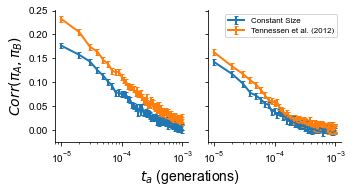

In [8]:

filt_df1 = test_df[(test_df.scenario == 'SerialConstant') & (test_df.Ne == 6958) & (test_df.ta == 0)]
filt_df2 = test_df[(test_df.scenario == 'TennessenEuropean') & (test_df.Ne == 10000) & (test_df.ta == 0)]

fig, ax = plt.subplots(1,2,figsize=(5,2.5), sharex=True, sharey=True)
ax[0].errorbar(filt_df1.rec_rate_mean, filt_df1.corr_s1_s2, 
            yerr=2*filt_df1.se_corr, capsize=2, lw=2, label=r'Constant Size')

ax[0].errorbar(filt_df2.rec_rate_mean, filt_df2.corr_s1_s2, 
            yerr=2*filt_df2.se_corr, capsize=2, lw=2, label=r'Tennessen et al. (2012)')
ax[0].set_xscale('log')


# Making the plot with new timepoints
filt_df1 = test_df[(test_df.scenario == 'SerialConstant') & (test_df.Ne == 6958) & (test_df.ta == 10000)]
filt_df2 = test_df[(test_df.scenario == 'TennessenEuropean') & (test_df.Ne == 10000) & (test_df.ta == 10000)]

ax[1].errorbar(filt_df1.rec_rate_mean, filt_df1.corr_s1_s2, 
            yerr=2*filt_df1.se_corr, capsize=2, lw=2, label=r'Constant Size')

ax[1].errorbar(filt_df2.rec_rate_mean, filt_df2.corr_s1_s2, 
            yerr=2*filt_df2.se_corr, capsize=2, lw=2, label=r'Tennessen et al. (2012)')

# Plotting aesthetics 
debox(ax[0]); debox(ax[1]);
ax[1].legend(fontsize=8)

# Setting labels
ax[0].set_ylabel(r'$Corr(\pi_A,\pi_B)$',fontsize=14);
fig.text(0.40, -0.025, r'$t_a$ (generations)', fontsize=14);
plt.savefig(supp_figdir + 'demo_test_v_constant.corr_piA_piB.pdf', dpi=300, bbox_inches='tight')